# Support Vector Machines in Python

**Support Vector Machines** are one of the best machine learning methods when getting the correct answer is a higher priority than understanding why you get the correct answer. Work well with relatively small datasets and they tend to work well 'out of the box', not requiring much optimization.

### Objectives for this notebook:
* Identifying and dealing with missing data
* Downsampling data
* Formatting the data for support vector machines
* Building a Preliminary SVM
* Optimizing parameters with cross validation
* Bulding, evaluation, drawing and interpreting the final SVM

#### Import the modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import scale #scale and center the data
from sklearn.svm import SVC # create the support vector classifier for SVM
from sklearn.model_selection import GridSearchCV # for cross validation
from sklearn.metrics import confusion_matrix # create confusion matrix
from sklearn.metrics import plot_confusion_matrix # plots confusion matrix
from sklearn.decomposition import PCA # perform PCA on the data
!pwd

/home/goncalo/Desktop/ML/SVM


**Import the dataset**

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

In [3]:
#df = pd.read_csv('default_of_credit_card_clients.ods', encoding='latin-1',
#                on_bad_lines='skip', lineterminator='\n')

df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls',
                  header = 1)
print('The columns in the data file:')
print(df.columns)
print('The sample contains ' + str(len(df)) + ' sources')
df.head()

The columns in the data file:
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
The sample contains 30000 sources


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


The columns are (see https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients):
* **ID**, The ID number assigned to each costumer
* **LIMIT_BALL**, Credit Limit
* **SEX**, Gender
* **EDUCATION**, Level of education
* **MARRIAGE**, Marital status
* **AGE**, Age
* **PAY_**, When the last 6 bills were payed
* **BLL_AMT**, What the last 6 bills were
* **PAY_AMT**, How much the alst payments were
* **default payment next month**

To change the last column name, since it's unpractical:

In [8]:
df.rename({'default payment next month' : 'DEFAULT'}, axis = 'columns', inplace = True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# A. Missing Data: scikit-learn's SVMs do not support datasets with missing values 

## Part 1: Identifying Missing Data

1. See what sort of data is in each column

In [10]:
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
DEFAULT      int64
dtype: object

We see that every column is int64, which is good, since it tells us that no numbers and letters are mixed. In other words, there are no NA or '?' values in df.

That said, we should still make sure each column contains acceptable values. See the documentation above to see which values are allowed in each column.

* **LIMIT_BAL**, The amount of available credit, **Integer**
* **SEX**, Gender (1 = male; 2 = female), **Category**
* **EDUCATION**, **Category**
    1 = graduate school
    2 = univerisity
    3 = high school
    4 = others
* **MARRIAGE**, **Category**
    1 = Married
    2 = Single
    3 = Other
* **AGE**, **Integer**
    -1 = Paid on time
    1 = Payment delayed by 1 month
    2 = Payment delayed by 2 months
    ...
    9 = Payment delayed by 9 or more months
* **BILL_AMT**, What the last 6 bills were, **Integer**
* **PAY_AMT**, How much the last payments were, **Integer**
* **DEFAULT**, Whether or not a person defaulted on the next payment, **Category**
    0 = Did not default
    1 = Defaulted
    
Let's start by making sure **SEX** only contains the numbers 1 and 2:

In [11]:
df['SEX'].unique()

array([2, 1])

Everything appears fine. Now let's check every other category:

In [17]:
for column in df.columns[1:]: # no need to check for ID column, every ID is a unique identifier
    print('Set of unique values in ', column, ' is: ', df[column].unique())

Set of unique values in  LIMIT_BAL  is:  [  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
Set of unique values in  SEX  is:  [2 1]
Set of unique values in  EDUCATION  is:  [2 1 3 5 4 6 0]
Set of unique values in  MARRIAGE  is:  [1 2 3 0]
Set of unique values in  AGE  is:  [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50

We see that, for reasons unkown, in addition to the allowed numbers 1, 2, 3 and 4, **EDUCATION** also contains 0, 5 and 6. Possibly, 0 represents missing data and 5 and 6 can be catagories not mentioned in the documentation, but that's just a guess.

Likewhise, **MARRIAGE** also contains a 0, which can be an indicator of missing data.

**In order to solve this problem, let's keep it simple and assume that 0 is missing data.**

## Part 2: Dealing with Missing Data

#### We will work with one of the two of the main ways of dealing with missing data (see https://www.kaggle.com/code/alexisbcook/missing-values):
* Remove rows (costumers) that contain missing data from the dataset
* Impute the values that are missing 

1. Search for rows with missing values for either df['EDUCATION'] or df['MARRIAGE']

In [19]:
df_miss = df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]
df_miss.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
218,219,110000,2,3,0,31,0,0,0,0,...,73315,63818,63208,4000,5000,3000,3000,3000,8954,0
809,810,160000,2,2,0,37,0,0,0,0,...,28574,27268,28021,35888,1325,891,1000,1098,426,0
820,821,200000,2,3,0,51,-1,-1,-1,-1,...,780,390,390,0,390,780,0,390,390,0
1019,1020,180000,2,3,0,45,-1,-1,-2,-2,...,0,0,0,0,0,0,0,0,0,0
1443,1444,200000,1,3,0,51,-1,-1,-1,-1,...,2529,1036,4430,5020,9236,2529,0,4430,6398,0


In [20]:
len(df_miss)

68

In [21]:
pm = (len(df_miss) / len(df)) * 100
print('The percentage of missing values in the original dataset is {:0.2f}.'.format(pm), '%.')

The percentage of missing values in the original dataset is 0.23. %.


**Since a small percentage of the data is missing, we can take the easy route and delete the rows with missing values, instead of imputing missing values**

In [23]:
df_no_missing = df.loc[(df.EDUCATION != 0) & (df.MARRIAGE != 0)]
df_no_missing.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [24]:
len(df_no_missing)

29932

**Verify that EDUCATION and MARRIAGE no longer contain missing values (0s)**

In [25]:
print(df.EDUCATION.unique()) # original dataset
df_no_missing.EDUCATION.unique()

[2 1 3 5 4 6 0]


array([2, 1, 3, 5, 4, 6])

In [26]:
print(df.MARRIAGE.unique()) # original dataset
df_no_missing.MARRIAGE.unique()

[1 2 3 0]


array([1, 2, 3])

***

# B. Downsample the data

**Support Vector Machines** are great with small datasets, but not awesome with large ones, and this dataset, while not huge, is big enough to take a long time to optimize with **Cross Validation**. So we need to downsample both category, customers who did and did not default, to 1000 each.

In [27]:
len(df_no_missing)

29932

The size of this dataset is a relatively large number for a SVM, so to downsampel to 1000 of each category, we start by splitting the data into two dataframes, one for people that did not default and one for people that did default.

In [29]:
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

Now downsample the dataset that did not default:

In [31]:
df_no_default_downsample = resample(df_no_default,
                                   replace = False, # no duplicates
                                   n_samples = 1000, # size of new sample
                                   random_state = 42 # deterministic outcome
                                   )

len(df_no_default_downsample)

1000

Do the same for the dataset of default:

In [33]:
df_default_downsample = resample(df_default,
                                   replace = False, # no duplicates
                                   n_samples = 1000, # size of new sample
                                   random_state = 42 # deterministic outcome
                                   )

len(df_default_downsample)

1000

Now let's merge the downsampled datasets into a single dataframe:

In [34]:
df_downsample = pd.concat([df_no_default_downsample, df_default_downsample])
len(df_downsample)

2000

***

# C. Format Data

## Part 1: Split the Data into Dependent and Independent Variables

**Now that we have taken care of the missing data, we are ready to start formatting the data for making a Support Vector Machine**

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications - We call this **X**
2. The columns of data that we want to predict - We call this **y**

**NOTE:** The reason we deal with missing data before splitting into **X** and **y** is that if we need to remove rows, splitting after ensures that each row in **X** corresponds with the appropriate value in **y**

In [56]:
# Make a new copy of the columns used to make predictions
# This ensures that when formatting the columns for classification trees, we can just re-copy df_no_mssing,
# rather than reload the original data and remove the missing values, etc..
X = df_downsample.drop('DEFAULT', axis=1).copy() # remove y from the classification data
#X = df_no_missing.iloc[:,:-1] # copys the entire dataframe except the last column, which is what we want to predict
X.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,642,130000,2,3,1,28,0,0,0,0,...,50000,0,0,0,2500,1000,0,0,0,0
4678,4679,170000,1,3,1,29,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,16005,180000,2,2,1,29,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,22975,210000,2,2,2,32,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,17536,190000,2,3,1,45,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [37]:
# Make a new copy of the data we want to predict
y = df_downsample['DEFAULT'].copy()
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: DEFAULT, dtype: int64

Now that we have created X, which is the data we want to use to make predictions, and y, which has the data we want to predict, we are ready to continue formatting X so that it is suitable for making a **Support Vector Machine**

## Part 2: One-Hot Encoding

**Now that we have split the dataframe into two pieces, X and y, we need to take a closer look at the variables in X.**

The list below tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

* **LIMIT_BAL**, The amount of available credit, **Integer**
* **SEX**, Gender (1 = male; 2 = female), **Category**
* **EDUCATION**, **Category**
         1 = graduate school
         2 = univerisity
         3 = high school
         4 = others
* **MARRIAGE**, **Category**
        1 = Married
        2 = Single
        3 = Other
* **AGE**, **Integer**
        -1 = Paid on time
        1 = Payment delayed by 1 month
        2 = Payment delayed by 2 months
        ...
        9 = Payment delayed by 9 or more months
* **BILL_AMT**, What the last 6 bills were, **Integer**
* **PAY_AMT**, How much the last payments were, **Integer**
* **DEFAULT**, Whether or not a person defaulted on the next payment, **Category**
        0 = Did not default
        1 = Defaulted

We see that **SEX, EDUCATION, MARRIAGE AND PAY_** are supposed to be categorical and need to be modified. This is because, while scikit learn **Support Vector Machines** natively support continuous data, like **LIMIT_BAL** and **AGE**, they do not natively support categorical data, liek **MARRIAGE**, which contains 3 different categories. Thus, we have to convert columns of categorical data into multiple columns of binary values using **One-Hot Encoding** (see https://www.kaggle.com/code/alexisbcook/categorical-variables)

If we did not perform this step, for example, for the **MARRIAGE** column, we have 3 options:

    1. Married
    2. Single
    3. Other
   
If we treated these values, 1, 2 and 3, like continuous data, then we would assume that 3, which means 'other', is more similar to 2, which means 'single, than it is to 1, which means 'married'. That means the support vector amchien would be more likely to cluster the people with 3s and 2s together than the people with 3s and 1s together. In contrast, if we treat these numbers like categorical data, then we treat each one as a separate category that is no more or less similar to any of the other categories. Thus, the likelihood of clustering people with 3s with 2s is the same as clustering 3s with 1s, and that approach is more reasonable.


**NOTE**: There are many different ways to do **One-Hot Encoding** in Python. Two of the more popular methods are:

* ColumnTransformer() from Scikit-learn - more commonly used in production systems and has more features
* get_dummies() from Pandas - easiest to do and easier to verify that it worked as intended

First, before we commit to converting cp with **One-Hot Encoding**, let's just just see what happens when we convert solely **MARRIAGE** without saving the results:

In [39]:
pd.get_dummies(X, columns = ['MARRIAGE']).head()

,ID,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
641,642,130000,2,3,28,0,0,0,0,-2,...,0,2500,1000,0,0,0,0,1,0,0
4678,4679,170000,1,3,29,0,0,0,0,0,...,33862,7200,7500,1200,1200,1500,1300,1,0,0
16004,16005,180000,2,2,29,0,0,0,0,0,...,26176,1800,1800,1500,1056,950,1000,1,0,0
22974,22975,210000,2,2,32,-2,-2,-2,-2,-2,...,0,979,412,0,0,0,0,0,1,0
17535,17536,190000,2,3,45,0,0,0,0,0,...,84811,3300,3331,3359,2663,2751,3000,1,0,0


Here:
* MARRIAGE_1 is for any person that had a 1 (married)
* MARRIAGE_2 is for any person that had a 2 (single)
* MARRIAGE_3 is for any person that had a 3 (other)

Now that we see how get_dummies() works, let's use it in on the four categorical columns that have more than 2 categories and save the result:

In [40]:
X_encoded = pd.get_dummies(X, columns = ['SEX',
                                        'EDUCATION',
                                        'MARRIAGE',
                                        'PAY_0',
                                        'PAY_2',
                                        'PAY_3',
                                        'PAY_4',
                                        'PAY_5',
                                        'PAY_6'])
X_encoded.head()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,642,130000,28,100143,50456,50000,0,0,0,2500,...,0,1,0,0,0,0,0,0,0,0
4678,4679,170000,29,165027,168990,172307,35234,32869,33862,7200,...,0,0,0,1,0,0,0,0,0,0
16004,16005,180000,29,25781,26000,26310,26662,26166,26176,1800,...,0,0,0,1,0,0,0,0,0,0
22974,22975,210000,32,355,975,410,0,0,0,979,...,0,1,0,0,0,0,0,0,0,0
17535,17536,190000,45,76433,78472,80548,81778,83082,84811,3300,...,0,0,0,1,0,0,0,0,0,0


## Part 3: Centering and Scaling

The **Radial Basis Function (RBF)** that we will use with our SVM assumes that the data are centered and scaled. In other words, each column should have a mean value = 0 and a standard deviation = 1. We need to then standardized each column in both the training and testing datasets.

**NOTE**: We split the data into trainign and testing datasets and then scale them separately to avoid **Data Leakage**. This occurs when information about the trainign dataset corrupts or influences the testing dataset.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)

X_train_scaled = scale(X_train) # outputs an array of arrays for each column with the values
X_test_scaled = scale(X_train) # we should use the mean and standard deviation from the training dataset

X_train_scaled

array([[ 0.68027283,  1.06764453,  0.66459398, ...,  0.        ,
        -0.0365392 , -0.05170877],
       [ 0.34369219,  0.11806446, -0.8151    , ...,  0.        ,
        -0.0365392 , -0.05170877],
       [-0.43654194, -0.51498893, -0.92079242, ...,  0.        ,
        -0.0365392 , -0.05170877],
       ...,
       [ 0.94662663,  1.22590788, -0.39233029, ...,  0.        ,
        -0.0365392 , -0.05170877],
       [-0.154364  , -0.27759391,  1.61582582, ...,  0.        ,
        -0.0365392 , -0.05170877],
       [-0.60644932, -1.06891064, -1.34356213, ...,  0.        ,
        -0.0365392 , -0.05170877]])

# D. Build a Preliminary Support Vector Machine

We can now test a first attemp at building our SVM:

In [46]:
clf_svm = SVC(random_state = 42) # create the instance of the model
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

Let's see how it performs on the **Testing Dataset** and draw a **Confusion Matrix**

/home/goncalo/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


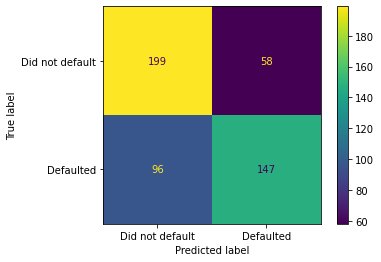

In [48]:
plot_confusion_matrix(clf_svm,
                    X_test_scaled,
                    y_test,
                    values_format='d',
                    display_labels=['Did not default','Defaulted'])

We see that 257 people that did not default, 201 (79%) were correctly classified and that of the 243 people that defaulted, 148 (61%) were correctly classified. Now let's attempt to do better. To improve the predictions, let's use cross validations to optimize the parameters.

# E. Optimize Parameters with Cross Validation and GridSearchCV()

Optimizing a **Support Vector Machine** is all about finding the best value for **gamma**, and, potentially, the regularization parameter, **C**. So let's see if we can find better parameters values using cross validation in hope that we can improve the accuracy with the testing dataset.

Since we have two parameters to optimize, we will use **GridSearchCV()**. We specify multiple potential values for **gamma** and **C**, and GridSearchCV() tests all possible combinations of the parameters for us.

In [52]:
param_grid = [
    {'C': [0.5, 1, 10, 100], # NOTE: Values for C > 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}
]

# Note: We are including C = 1 and gamma = 'scale' as possible choices since they are the default values

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv = 5,
        scoring = 'accuracy',
        verbose = 0 # Note: if you want to see what Grid Search is doing, set verbose = 2
) ## accuracy is default scoring - try others

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


We see that the ideal value for C = 100, which means we will use regularization, and the ideal value for gamma = 0.001

# F. Building, Evaluating, Drawing and Interpreting the Final SVM

In [53]:
clf_svm = SVC(random_state = 42, C = 100, gamma = 0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

/home/goncalo/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


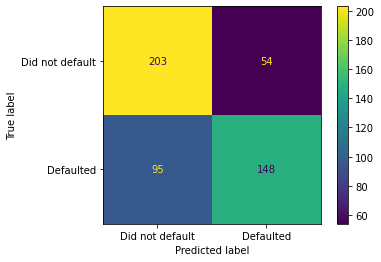

In [54]:
plot_confusion_matrix(clf_svm,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels = ['Did not default','Defaulted'])

As we see, these values from the **optimized SVM** are slightly better than before. Thus, the SVM was pretty good straight out of the box without much optimization and this is what makes SVMs a great and quick method for relatively small datasets.

The last thing we are going to draw is a support vecotr machine decision boundary and interpret it. The first thing we need to do is count the number of columns in X:

In [72]:
df_downsample.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

In [73]:
len(df_downsample.drop('DEFAULT', axis=1).columns)

24

So we see that there are 24 features, or columns in **X**. This is a problem because it would require a 24-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. If we wanted to, we could just pick two features at random to use as x and y-axes on our graph, but instead, we can use the **PCA (Principal Analysis Component)** to combine the 24 features into two orthogonal meta-features that we can use as axes for a graph.

However, before we shrink the graph, let's first detemine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2D graph. If not, the shrunken graph will not be very useful. To determine the accuracy of the graph we can draw a **scree plot**

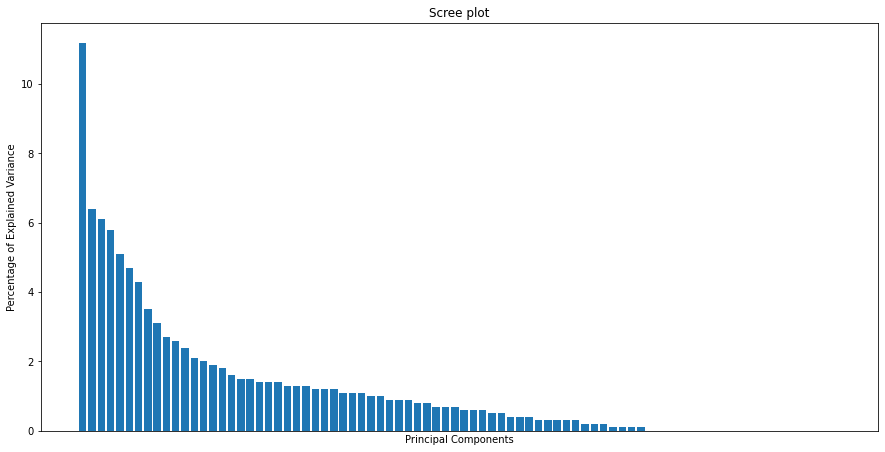

In [74]:
pca = PCA() # Note: By default, PCA() centers the data but does not scale it
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals = 1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(15, 7.5))
plt.bar(x=range(1, len(per_var) +1), height=per_var)
plt.tick_params(
    axis='x', # changes apply to x-axis
    which='both', # both major and minor ticks are affected
    bottom=False, # ticks along the bottom edge are off
    top=False, # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2D graph. However, PC2 is not much different from PC3 or PC4, which doesn't bode well for dimension reduction. So, we shouldn't expect our final graph to look as good as we wish it to be.

In [75]:
train_pc1_coords = X_train_pca[:,0] # select PC1
train_pc2_coords = X_train_pca[:,1] # select PC2

# NOTE:
# PC1 contains the x-axis coordinates of the data after PCA
# PC2 contains the y-axis coordiantes fo the data after PCA

## Now center and scale the PCs
pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

# Now we optimize the SVM fit to the x and y-axis coordinates
# The different here is that instead of using the 24 features to train the data
# we only select the 2 most important ones
param_grid = [
    {'C': [1, 10, 100, 1000], # NOTE: Values for C > 0
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']}
]

# Note: We are including C = 1 and gamma = 'scale' as possible choices since they are the default values

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv = 5,
        scoring = 'accuracy',
        verbose = 0 # Note: if you want to see what Grid Search is doing, set verbose = 2
) ## accuracy is default scoring - try others


optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


Finally, plot the graph with the optimal values for C and gamma:

<function matplotlib.pyplot.show(close=None, block=None)>

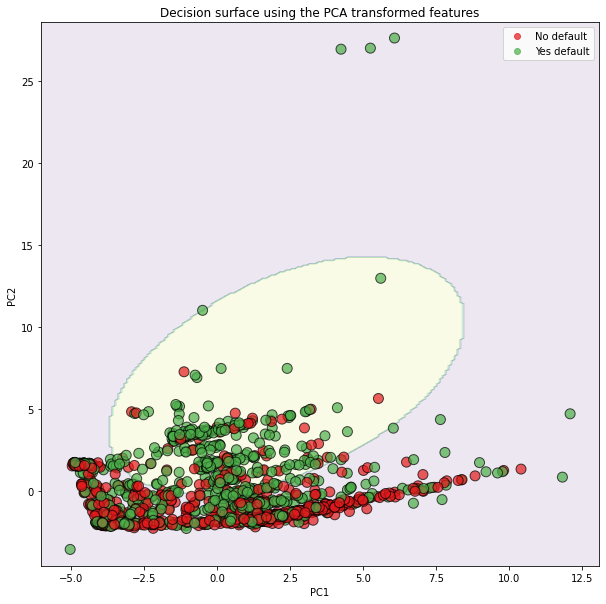

In [88]:
clf_svm = SVC(random_state=42, C = 1000, gamma = 0.001)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA
X_test_pca = pca.transform(X_train_scaled) # for train dataset
#X_test_pca = pca.transform(X_test_scaled) # for test dataset

test_pc1_coords = X_test_pca[:,0] # select PC1
test_pc2_coords = X_test_pca[:,1] # select PC2

## Now create a matrix of points that we can use to show the decision regions
## The matrix will be slightly larger than the transformed PCA points so that
## we can plot all of the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() -1 # limits for the matrix
x_max = test_pc1_coords.max() +1
y_min = test_pc2_coords.min() -1
y_max = test_pc2_coords.max() +1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1), # create the matrix
                     np.arange(start=y_min, stop=y_max, step=0.1))

## Now we classify every point in the matrix with the SVM
## Points on one side of the classification boundary will get 0,
## while points on the other side will get 1
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))
## Z is just a long array of lots of 0s and 1s, which reflect how each point
## in the mesh was classified.
## We use reshape so that each classification (0 or 1) corresponds to
## a specific point in the matrix
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx,yy, Z, alpha = 0.1)

## Now create custom colors for the actual datapoints
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])
## draw the actual data points - these will be colored by their
## known (not predicted) classifications
## Note: setting alpha = 0.7 let's us see if we are covering up a point
scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c = y_train, # for train dataset
#scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c= y_test, # for test dataset
                    cmap=cmap,
                    s=100,
                    edgecolors='k', # k = black
                    alpha = 0.7)

## create a legend
legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                  loc = 'upper right')
legend.get_texts()[0].set_text('No default')
legend.get_texts()[1].set_text('Yes default')

## Now add ais labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed features')
plt.show

That's it. We have the following:

* **The pink part of the graph is the area where all datapoints will be predicted to have not defaulted.**
* **The yellow part of the graph is the area where all datapoints will be predicted to have defaulted**
* **The dots are datapoints in the training/testing dataset and are color coded by their known classifications: red is for those that did not default and green is for those that defaulted.**



**NOTE**: The results here are for the training data, not the testing data, and thus, do not match the confusion matrices that we generated. Also, remember that for this picture, we only fit the SVM to the first two principal components instead of all the data, and thus, this is only an approximation of the true classifier. Lastly, because the skree plot showed that PC2 was not very different from PC3 or PC4, this is not a very good approximation, as both PC3 or PC4 would produce a similar result together with PC1.